In [1]:
import os
seed = 0
os.environ['PYTHONHASSEED'] = str(seed)

In [2]:
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import pickle

from tensorflow.random import set_seed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [4]:
# Set seed
random.seed(seed)
np.random.seed(seed)
set_seed(seed)

In [5]:
filename = '../data/turbofan_dataset/N-CMAPSS_DS02-006.h5'
output_path = 'DS02/experiment_set_8'

In [6]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [7]:
def load_dataset(filename, load_test_set=True):
    """ Reads a dataset from a given .h5 file and compose (in memory) the train and test data. 
    Args:
        filename(str): path to the .h5 file
    Returns:
        train_set(pd.DataFrame), test_set(pd.DataFrame)
    """
    with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        if load_test_set:
            W_test = np.array(hdf.get('W_test'))           # W
            X_s_test = np.array(hdf.get('X_s_test'))       # X_s
            X_v_test = np.array(hdf.get('X_v_test'))       # X_v
            T_test = np.array(hdf.get('T_test'))           # T
            Y_test = np.array(hdf.get('Y_test'))           # RUL  
            A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Column names
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        columns = []
        columns.append(list(np.array(A_var, dtype='U20')))
        columns.append(list(np.array(T_var, dtype='U20')))
        columns.append(list(np.array(X_s_var, dtype='U20')))
        columns.append(list(np.array(X_v_var, dtype='U20')))
        columns.append(list(np.array(W_var, dtype='U20')))
        columns.append(['RUL'])
        
        columns_list = []
        for columns_per_category in columns:
            columns_list += columns_per_category
        
    train_set = np.concatenate((A_dev, T_dev, X_s_dev, X_v_dev, W_dev, Y_dev), axis=1)
    if load_test_set:
        test_set = np.concatenate((A_test, T_test, X_s_test, X_v_test, W_test, Y_test), axis=1)
        return pd.DataFrame(data=train_set, columns=columns_list), pd.DataFrame(data=test_set, columns=columns_list), columns
    else:
        return pd.DataFrame(data=train_set, columns=columns_list), None, columns

In [8]:
def unit_cycle_info(df, compute_cycle_len=False):
    unit_ids = np.unique(df['unit'])
    print('Engine units in df: ', unit_ids)
    for i in unit_ids:
        num_cycles = len(np.unique(df.loc[df['unit'] == i, 'cycle']))
        print('Unit: ', i, ' - Number of flight cycles: ', num_cycles)
        
    if compute_cycle_len:
        cycle_ids = np.unique(df['cycle'])
        print('Total number of cycles: ', len(cycle_ids))
        min_len = np.inf
        max_len = 0
        for i in cycle_ids:
            cycle_len = len(df.loc[df['cycle'] == i, 'cycle'])
            if cycle_len < min_len:
                min_len = cycle_len
            elif cycle_len > max_len:
                max_len = cycle_len
        print('Min cycle length: ', min_len)
        print('Max cycle length: ', max_len)
    
    return unit_ids

In [9]:
# Filter constant and quasi-constant features
def get_quasi_constant_features(dataset, variance_th=0.01, debug=True):
    constant_filter = VarianceThreshold(threshold=variance_th)
    constant_filter.fit(dataset)
    constant_features = [col for col in dataset.columns 
                         if col not in dataset.columns[constant_filter.get_support()]]
    
    if debug:
        print("Number of non-constant features: ", len(dataset.columns[constant_filter.get_support()]))
        
        print("Number of quasi-constant features: ", len(constant_features))
        print("Quasi-constant features: ")
        for col in constant_features:
            print(col)
    return constant_features

def get_non_correlated_features(dataset, corr_th=0.9, debug=True):
    corr_mat = dataset.corr()
    corr_mat = np.abs(corr_mat)
    
    num_cols = corr_mat.shape[0]
    columns = np.full((num_cols,), True, dtype=bool)
    for i in range(num_cols):
        for j in range(i+1, num_cols):
            val = corr_mat.iloc[i, j]
            if val >= corr_th:
                if columns[j]:
                    columns[j] = False
                    if debug:
                        print(dataset.columns[i], "|", dataset.columns[j], "|", round(val, 2))
    if debug:        
        correlated_features = dataset.columns[~columns]
        print("Number of correlated features: ", len(correlated_features))
        print("Correlated features: ", list(correlated_features))
    
    selected_columns = dataset.columns[columns]
    if debug:
        print("Number of selected features: ", len(selected_columns))
        print("Selected features: ", list(selected_columns))
    return selected_columns

def cmapss_score_function(actual, predictions, normalize=True):
    # diff < 0 -> over-estimation
    # diff > 0 -> under-estimation
    diff = actual - predictions
    alpha = np.full_like(diff, 1/13)
    negative_diff_mask = diff < 0
    alpha[negative_diff_mask] = 1/10
    score = np.sum(np.exp(alpha * np.abs(diff)))
    
    if normalize:
        N = len(predictions)
        score /= N
    return score

def compute_evaluation_metrics(actual, predictions, label='Test'):
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    cmapss_score = cmapss_score_function(actual, predictions)
    print('{} set:\nMSE: {:.2f}\nRMSE: {:.2f}\nCMAPSS score: {:.2f}\n'.format(label, mse, rmse, 
                                                                     cmapss_score))
    return mse, rmse, cmapss_score
    
def plot_loss_curves(history, output_path=None, y_lim=[0, 150]):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(y_lim)
    plt.legend(['train', 'validation'], loc='upper left')
    
    if output_path is not None:
        plt.savefig(os.path.join(output_path, 'loss_curves.png'), format='png', dpi=300) 
    plt.show()
    
def plot_rul(expected, predicted):
    plt.figure()
    plt.plot(range(len(expected)), expected, label='Expected')
    plt.plot(range(len(predicted)), predicted, label='Predicted')
    plt.legend()
    
    
def create_mlp_model(input_dim, hidden_layer_sizes, activation='relu', output_weights_file=None):
    model = Sequential()
    model.add(Dense(hidden_layer_sizes[0], 
                    input_dim=input_dim, 
                    kernel_initializer='random_normal', 
                    activation=activation))

    for layer_size in hidden_layer_sizes[1:]:
        model.add(Dense(layer_size, 
                        kernel_initializer='random_normal', 
                        activation=activation))
    
    model.add(Dense(1, kernel_initializer='random_normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    if output_weights_file is not None:
        model.save_weights(output_weights_file)
    return model

def train_model_existing_weights(model, weights_file, x_train, y_train, x_val, y_val, epochs=200, batch_size=512, callbacks=[]):
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.load_weights(weights_file)
    return model.fit(x_train, y_train,
                     validation_data=(x_val, y_val),
                     epochs=epochs,
                     batch_size=batch_size,
                     verbose=1,
                     callbacks=callbacks)

def save_history(history, output_file=os.path.join(output_path, "history.pkl")):
    with open(output_file, 'wb') as file:
        pickle.dump(history.history, file)
    print("Saved training history to file: {}".format(output_file))

def load_history(file):
    return pickle.load(open(file, "rb"))

def model_evaluation(model, x_test, y_test, x_train=None, y_train=None, plot_range=[0, 10**3]):
    if x_train is not None and y_train is not None:
        predictions_train = model.predict(x_train).flatten()
        compute_evaluation_metrics(predictions_train, y_train, 'Train')
        
        expected = y_train[plot_range[0]:plot_range[1]]
        predicted = predictions_train[plot_range[0]:plot_range[1]]
        plot_rul(expected, predicted)
        
    predictions_test = model.predict(x_test).flatten()
    compute_evaluation_metrics(predictions_test, y_test)
    
    expected = y_test[plot_range[0]:plot_range[1]]
    predicted = predictions_test[plot_range[0]:plot_range[1]]
    plot_rul(expected, predicted)

In [10]:
def write_list(string_list, output_file):
    output_file.write("[")
    n = len(string_list)
    for i in range(n - 1):
        output_file.write("{}, ".format(string_list[i]))
    output_file.write("{}]\n".format(string_list[-1]))

In [11]:
start_time = time.process_time()  
train_set, test_set, columns = load_dataset(filename)
print("Operation time (sec): " , (time.process_time() - start_time))
print()
print("Train set shape: " + str(train_set.shape))

columns_aux = columns[0] 
columns_health_params = columns[1] 
columns_sensor_measurements = columns[2] 
columns_virtual_sensors = columns[3]
columns_operating_conditions = columns[4] 
target_col = columns[5]

Operation time (sec):  3.796875

Train set shape: (5263447, 47)


In [12]:
y_train = train_set['RUL']
x_train = train_set.drop(['RUL'], axis=1)

In [13]:
initial_columns = x_train.columns
selected_columns_1 = columns_sensor_measurements + columns_virtual_sensors + columns_operating_conditions

x_train.drop(labels=[x for x in initial_columns if x not in selected_columns_1], axis=1, inplace=True)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_17 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 238,721
Trainable params: 238,721
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
5034/5038 [============================>.] - ETA: 0s - loss: 169.1904
Epoch 00001: val_loss improved f

5038/5038 [==============================] - 24s 5ms/step - loss: 15.9137 - val_loss: 13.9435
Epoch 28/200
5032/5038 [============================>.] - ETA: 0s - loss: 15.6609
Epoch 00028: val_loss did not improve from 13.94348
5038/5038 [==============================] - 23s 5ms/step - loss: 15.6574 - val_loss: 14.9301
Epoch 29/200
5035/5038 [============================>.] - ETA: 0s - loss: 15.5720
Epoch 00029: val_loss improved from 13.94348 to 13.86644, saving model to DS02/experiment_set_8\results_all\mlp_model_trained.h5
5038/5038 [==============================] - 23s 5ms/step - loss: 15.5717 - val_loss: 13.8664
Epoch 30/200
5022/5038 [============================>.] - ETA: 0s - loss: 15.2567
Epoch 00030: val_loss improved from 13.86644 to 12.60709, saving model to DS02/experiment_set_8\results_all\mlp_model_trained.h5
5038/5038 [==============================] - 23s 5ms/step - loss: 15.2527 - val_loss: 12.6071
Epoch 31/200
5022/5038 [============================>.] - ETA: 0s - 

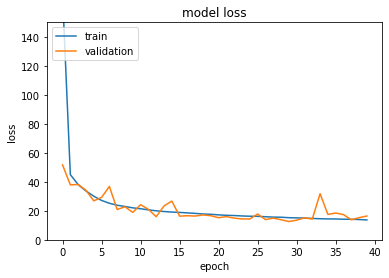

Test set:
MSE: 12.59
RMSE: 3.55
CMAPSS score: 1.25

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               4096      
_________________________________________________________________
dense_21 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_22 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_23 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 234,369
Trainable params: 234,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
5035/5038 [============================>.] - ETA: 

5034/5038 [============================>.] - ETA: 0s - loss: 13.5776
Epoch 00060: val_loss did not improve from 12.90136
5038/5038 [==============================] - 23s 5ms/step - loss: 13.5762 - val_loss: 13.2715
Epoch 61/200
5034/5038 [============================>.] - ETA: 0s - loss: 13.5143
Epoch 00061: val_loss did not improve from 12.90136
5038/5038 [==============================] - 23s 5ms/step - loss: 13.5124 - val_loss: 13.8848
Epoch 62/200
5022/5038 [============================>.] - ETA: 0s - loss: 13.5606
Epoch 00062: val_loss did not improve from 12.90136
5038/5038 [==============================] - 23s 5ms/step - loss: 13.5561 - val_loss: 13.6332
Epoch 63/200
5035/5038 [============================>.] - ETA: 0s - loss: 13.4193
Epoch 00063: val_loss did not improve from 12.90136
5038/5038 [==============================] - 23s 5ms/step - loss: 13.4194 - val_loss: 16.5311
Epoch 64/200
5036/5038 [============================>.] - ETA: 0s - loss: 13.3413
Epoch 00064: val_lo

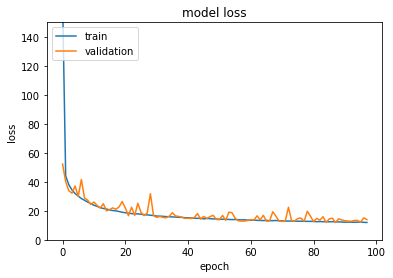

Test set:
MSE: 11.91
RMSE: 3.45
CMAPSS score: 1.24

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               2048      
_________________________________________________________________
dense_26 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_27 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_28 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 232,321
Trainable params: 232,321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
5038/5038 [==============================] - ETA: 

Epoch 28/200
5026/5038 [============================>.] - ETA: 0s - loss: 38.9703
Epoch 00028: val_loss did not improve from 36.91401
5038/5038 [==============================] - 23s 5ms/step - loss: 38.9646 - val_loss: 38.2019
Epoch 29/200
5035/5038 [============================>.] - ETA: 0s - loss: 38.6301
Epoch 00029: val_loss did not improve from 36.91401
5038/5038 [==============================] - 23s 5ms/step - loss: 38.6344 - val_loss: 60.4135
Epoch 30/200
5031/5038 [============================>.] - ETA: 0s - loss: 38.4840
Epoch 00030: val_loss did not improve from 36.91401
5038/5038 [==============================] - 23s 5ms/step - loss: 38.4877 - val_loss: 41.2018
Epoch 31/200
5027/5038 [============================>.] - ETA: 0s - loss: 37.9989
Epoch 00031: val_loss improved from 36.91401 to 36.66567, saving model to DS02/experiment_set_8\results_0.95\mlp_model_trained.h5
5038/5038 [==============================] - 23s 5ms/step - loss: 38.0043 - val_loss: 36.6657
Epoch 32/2

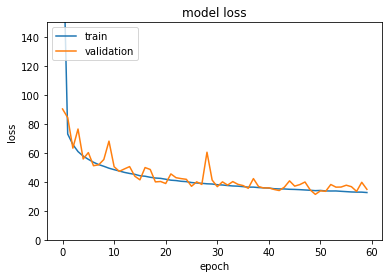

Test set:
MSE: 31.24
RMSE: 5.59
CMAPSS score: 1.66

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 256)               1536      
_________________________________________________________________
dense_31 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_32 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_33 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
Total params: 231,809
Trainable params: 231,809
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
5029/5038 [============================>.] - ETA: 

5038/5038 [==============================] - 23s 5ms/step - loss: 44.6481 - val_loss: 41.7033
Epoch 28/200
5031/5038 [============================>.] - ETA: 0s - loss: 44.3786
Epoch 00028: val_loss did not improve from 41.70329
5038/5038 [==============================] - 23s 5ms/step - loss: 44.3800 - val_loss: 47.3247
Epoch 29/200
5028/5038 [============================>.] - ETA: 0s - loss: 44.1325
Epoch 00029: val_loss did not improve from 41.70329
5038/5038 [==============================] - 23s 4ms/step - loss: 44.1276 - val_loss: 43.5566
Epoch 30/200
5025/5038 [============================>.] - ETA: 0s - loss: 43.4893
Epoch 00030: val_loss did not improve from 41.70329
5038/5038 [==============================] - 22s 4ms/step - loss: 43.5002 - val_loss: 55.1596
Epoch 31/200
5028/5038 [============================>.] - ETA: 0s - loss: 43.4441
Epoch 00031: val_loss did not improve from 41.70329
5038/5038 [==============================] - 23s 5ms/step - loss: 43.4521 - val_loss: 44

Epoch 62/200
5034/5038 [============================>.] - ETA: 0s - loss: 36.5015
Epoch 00062: val_loss did not improve from 36.03455
5038/5038 [==============================] - 24s 5ms/step - loss: 36.5007 - val_loss: 38.7236
Epoch 63/200
5038/5038 [==============================] - ETA: 0s - loss: 36.4189
Epoch 00063: val_loss did not improve from 36.03455
5038/5038 [==============================] - 24s 5ms/step - loss: 36.4189 - val_loss: 39.0980
Epoch 64/200
5029/5038 [============================>.] - ETA: 0s - loss: 36.2023
Epoch 00064: val_loss did not improve from 36.03455
5038/5038 [==============================] - 23s 5ms/step - loss: 36.2004 - val_loss: 37.7818
Epoch 65/200
5035/5038 [============================>.] - ETA: 0s - loss: 36.2275
Epoch 00065: val_loss improved from 36.03455 to 36.01286, saving model to DS02/experiment_set_8\results_0.9\mlp_model_trained.h5
5038/5038 [==============================] - 25s 5ms/step - loss: 36.2265 - val_loss: 36.0129
Epoch 66/20

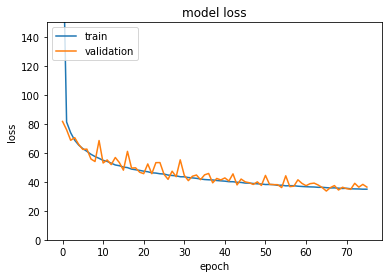

Test set:
MSE: 33.55
RMSE: 5.79
CMAPSS score: 1.59



In [26]:
######################################
# Test effect of correlation threshold
######################################

batch_size = 512
epochs = 200
layer_sizes = [256, 256, 512, 64]

initial_columns = x_train.columns
corr_th_list = [None, 0.99, 0.95, 0.9]

results_file = os.path.join(output_path, "results.txt")
open(results_file, "w").close()

for corr_th in corr_th_list:
    # Select features based on training set
    if corr_th is not None:
        selected_columns = get_non_correlated_features(x_train, corr_th=corr_th, debug=False)
    else:
        selected_columns = x_train.columns
    
    x_train_feature_selection = x_train[selected_columns]
    
    # Train-validation split for early stopping
    x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_feature_selection, 
                                                                              y_train, 
                                                                              test_size=0.3, 
                                                                              random_state=seed)
    # Create output path
    results_folder = "results_all" if corr_th is None else "results_{}".format(corr_th)
    results_path = os.path.join(output_path, results_folder)
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    
    # Standardization
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_split)
    x_val_scaled = scaler.transform(x_val_split)
    input_dim = x_train_scaled.shape[1]

    # Create model
    weights_file = os.path.join(results_path, 'mlp_initial_weights.h5')
    model_path = os.path.join(results_path, 'mlp_model_trained.h5')
    model = create_mlp_model(input_dim, layer_sizes, activation='tanh', 
                             output_weights_file=weights_file)
    model.summary()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

    # Train model
    history = train_model_existing_weights(model, weights_file, 
                                           x_train_scaled, y_train_split, 
                                           x_val_scaled, y_val_split, 
                                           batch_size=batch_size, 
                                           epochs=epochs, 
                                           callbacks=[es, mc])
    
    history_file = os.path.join(results_path, "history.pkl")
    save_history(history, history_file)
    plot_loss_curves(history.history, output_path=results_path)
    
    # Performance evaluation
    x_test_feature_selection = x_test[selected_columns]
    x_test_scaled = scaler.transform(x_test_feature_selection)
    
    loaded_model = load_model(model_path)
    predictions_test = loaded_model.predict(x_test_scaled).flatten()
    mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_test, y_test)
    
    with open(results_file, "a", newline='') as file:
        file.write("Experiment {}\n".format(corr_th if corr_th is not None else "ALL"))
        file.write("Selected columns: ")
        write_list(selected_columns, file)
        file.write("MSE = {}\nRMSE = {}\nCMAPSS = {}\n\n\n".format(mse, rmse, cmapss_score))

In [17]:
######################################
# Test effect of correlation threshold
######################################
NUM_TRIALS = 3

batch_size = 512
epochs = 200
layer_sizes = [256, 256, 512, 64]

initial_columns = x_train.columns
corr_th_list = [None, 0.99, 0.95, 0.9]

results_file = os.path.join(output_path, "results.txt")
open(results_file, "w").close()

for corr_th in corr_th_list:
    # Select features based on training set
    if corr_th is not None:
        selected_columns = get_non_correlated_features(x_train, corr_th=corr_th, debug=False)
    else:
        selected_columns = x_train.columns
    
    x_train_feature_selection = x_train[selected_columns]
    
    mse_vals = []
    rmse_vals = []
    cmapss_vals = []
    
    for random_seed in range(NUM_TRIALS):
        # Train-validation split for early stopping
        x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_feature_selection, 
                                                                                  y_train, 
                                                                                  test_size=0.3, 
                                                                                  random_state=seed)
        # Create output path
        results_folder = "results_all" if corr_th is None else "results_{}".format(corr_th)
        results_path_crr_th = os.path.join(output_path, results_folder)
        results_path_crr_split = os.path.join(results_path_crr_th, "split_{}".format(random_seed))
        if not os.path.exists(results_path_crr_split):
            os.makedirs(results_path_crr_split)

        # Standardization
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train_split)
        x_val_scaled = scaler.transform(x_val_split)
        input_dim = x_train_scaled.shape[1]

        # Create model
        weights_file = os.path.join(results_path_crr_th, 'mlp_initial_weights.h5')
        model_path = os.path.join(results_path_crr_split, 'mlp_model_trained.h5')
        model = create_mlp_model(input_dim, layer_sizes, activation='tanh')
        model.summary()

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=2, 
                             save_best_only=True)

        # Train model
        history = train_model_existing_weights(model, weights_file, 
                                               x_train_scaled, y_train_split, 
                                               x_val_scaled, y_val_split, 
                                               batch_size=batch_size, 
                                               epochs=epochs, 
                                               callbacks=[es, mc])

        history_file = os.path.join(results_path_crr_split, "history.pkl")
        save_history(history, history_file)

        # Performance evaluation
        x_test_feature_selection = x_test[selected_columns]
        x_test_scaled = scaler.transform(x_test_feature_selection)

        loaded_model = load_model(model_path)
        predictions_test = loaded_model.predict(x_test_scaled).flatten()
        mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_test, y_test)
        
        mse_vals.append(mse)
        rmse_vals.append(rmse)
        cmapss_vals.append(cmapss_score)
    
    mse_mean = np.mean(mse_vals)
    mse_std = np.std(mse_vals)
    rmse_mean = np.mean(rmse_vals)
    rmse_std = np.std(rmse_vals)
    cmapss_mean = np.mean(cmapss_vals)
    cmapss_std = np.std(cmapss_vals)
    
    with open(results_file, "a", newline='') as file:
        file.write("Experiment {}\n".format(corr_th if corr_th is not None else "ALL"))
        file.write("Selected columns: ")
        write_list(selected_columns, file)
        file.write("Number of features: {}".format(len(selected_columns)))
        file.write("\nMSE = ")
        write_list(mse_vals, file)
        file.write("\nMSE mean = {}\nMSE std = {}\n".format(mse_mean, mse_std))
        
        file.write("\nRMSE = ")
        write_list(rmse_vals, file)
        file.write("\nRMSE mean = {}\nRMSE std = {}\n".format(rmse_mean, rmse_std))
        
        file.write("\nCMAPSS = ")
        write_list(cmapss_vals, file)
        file.write("\nCMAPSS mean = {}\nCMAPSS std = {}\n".format(cmapss_mean, cmapss_std))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 238,721
Trainable params: 238,721
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
5027/5038 [============================>.] - ETA: 0s - loss: 169.4341
Epoch 00001: val_loss improved f

Test set:
MSE: 15.20
RMSE: 3.90
CMAPSS score: 1.30

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 238,721
Trainable params: 238,721
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
5036/5038 [============================>.] - ETA: 

Epoch 28/200
5027/5038 [============================>.] - ETA: 0s - loss: 15.6468
Epoch 00028: val_loss did not improve from 13.66935
5038/5038 [==============================] - 24s 5ms/step - loss: 15.6403 - val_loss: 15.6003
Epoch 29/200
5031/5038 [============================>.] - ETA: 0s - loss: 15.4177
Epoch 00029: val_loss did not improve from 13.66935
5038/5038 [==============================] - 24s 5ms/step - loss: 15.4153 - val_loss: 15.0630
Epoch 30/200
5036/5038 [============================>.] - ETA: 0s - loss: 15.1845
Epoch 00030: val_loss improved from 13.66935 to 13.30455, saving model to DS02/experiment_set_8\results_all\split_1\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 15.1839 - val_loss: 13.3046
Epoch 31/200
5032/5038 [============================>.] - ETA: 0s - loss: 15.2408
Epoch 00031: val_loss did not improve from 13.30455
5038/5038 [==============================] - 24s 5ms/step - loss: 15.2438 - val_loss: 16.9943
Epo

5038/5038 [==============================] - 25s 5ms/step - loss: 24.0414 - val_loss: 20.9713
Epoch 9/200
5030/5038 [============================>.] - ETA: 0s - loss: 22.8400
Epoch 00009: val_loss improved from 20.97129 to 18.35376, saving model to DS02/experiment_set_8\results_all\split_2\mlp_model_trained.h5
5038/5038 [==============================] - 25s 5ms/step - loss: 22.8377 - val_loss: 18.3538
Epoch 10/200
5036/5038 [============================>.] - ETA: 0s - loss: 22.1294
Epoch 00010: val_loss did not improve from 18.35376
5038/5038 [==============================] - 24s 5ms/step - loss: 22.1284 - val_loss: 24.8601
Epoch 11/200
5028/5038 [============================>.] - ETA: 0s - loss: 21.6550
Epoch 00011: val_loss did not improve from 18.35376
5038/5038 [==============================] - 25s 5ms/step - loss: 21.6494 - val_loss: 21.3363
Epoch 12/200
5026/5038 [============================>.] - ETA: 0s - loss: 20.9364
Epoch 00012: val_loss did not improve from 18.35376
5038

Epoch 17/200
5037/5038 [============================>.] - ETA: 0s - loss: 19.8526
Epoch 00017: val_loss improved from 18.90743 to 18.38799, saving model to DS02/experiment_set_8\results_0.99\split_0\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 19.8527 - val_loss: 18.3880
Epoch 18/200
5038/5038 [==============================] - ETA: 0s - loss: 19.6944
Epoch 00018: val_loss did not improve from 18.38799
5038/5038 [==============================] - 24s 5ms/step - loss: 19.6944 - val_loss: 20.7426
Epoch 19/200
5029/5038 [============================>.] - ETA: 0s - loss: 19.0910
Epoch 00019: val_loss improved from 18.38799 to 17.65604, saving model to DS02/experiment_set_8\results_0.99\split_0\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 19.0929 - val_loss: 17.6560
Epoch 20/200
5032/5038 [============================>.] - ETA: 0s - loss: 18.6269
Epoch 00020: val_loss improved from 17.65604 to 17.60097, savi

Epoch 50/200
5032/5038 [============================>.] - ETA: 0s - loss: 14.2563
Epoch 00050: val_loss did not improve from 13.91340
5038/5038 [==============================] - 24s 5ms/step - loss: 14.2548 - val_loss: 14.8894
Epoch 51/200
5024/5038 [============================>.] - ETA: 0s - loss: 14.1428
Epoch 00051: val_loss did not improve from 13.91340
5038/5038 [==============================] - 24s 5ms/step - loss: 14.1436 - val_loss: 15.3078
Epoch 52/200
5034/5038 [============================>.] - ETA: 0s - loss: 14.0413
Epoch 00052: val_loss did not improve from 13.91340
5038/5038 [==============================] - 25s 5ms/step - loss: 14.0452 - val_loss: 16.7999
Epoch 53/200
5027/5038 [============================>.] - ETA: 0s - loss: 14.0762
Epoch 00053: val_loss did not improve from 13.91340
5038/5038 [==============================] - 24s 5ms/step - loss: 14.0782 - val_loss: 17.2753
Epoch 00053: early stopping
Saved training history to file: DS02/experiment_set_8\result

Epoch 24/200
5027/5038 [============================>.] - ETA: 0s - loss: 17.8758
Epoch 00024: val_loss improved from 18.44855 to 18.23912, saving model to DS02/experiment_set_8\results_0.99\split_1\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 17.8783 - val_loss: 18.2391
Epoch 25/200
5027/5038 [============================>.] - ETA: 0s - loss: 17.7901
Epoch 00025: val_loss improved from 18.23912 to 17.17035, saving model to DS02/experiment_set_8\results_0.99\split_1\mlp_model_trained.h5
5038/5038 [==============================] - 25s 5ms/step - loss: 17.7914 - val_loss: 17.1703
Epoch 26/200
5030/5038 [============================>.] - ETA: 0s - loss: 17.4750
Epoch 00026: val_loss did not improve from 17.17035
5038/5038 [==============================] - 24s 5ms/step - loss: 17.4733 - val_loss: 18.5672
Epoch 27/200
5028/5038 [============================>.] - ETA: 0s - loss: 17.0963
Epoch 00027: val_loss did not improve from 17.17035
5038/5038 

Epoch 57/200
5035/5038 [============================>.] - ETA: 0s - loss: 13.8356
Epoch 00057: val_loss did not improve from 13.32915
5038/5038 [==============================] - 24s 5ms/step - loss: 13.8359 - val_loss: 15.0542
Epoch 58/200
5029/5038 [============================>.] - ETA: 0s - loss: 13.7746
Epoch 00058: val_loss improved from 13.32915 to 13.19444, saving model to DS02/experiment_set_8\results_0.99\split_1\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 13.7732 - val_loss: 13.1944
Epoch 59/200
5037/5038 [============================>.] - ETA: 0s - loss: 13.7208
Epoch 00059: val_loss did not improve from 13.19444
5038/5038 [==============================] - 23s 5ms/step - loss: 13.7204 - val_loss: 13.9162
Epoch 60/200
5029/5038 [============================>.] - ETA: 0s - loss: 13.6349
Epoch 00060: val_loss did not improve from 13.19444
5038/5038 [==============================] - 23s 5ms/step - loss: 13.6329 - val_loss: 13.7937
Ep

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 256)               4096      
_________________________________________________________________
dense_31 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_32 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_33 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
Total params: 234,369
Trainable params: 234,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
5031/5038 [============================>.] - ETA: 0s - loss: 167.1330
Epoch 00001: val_loss improved f

Epoch 28/200
5038/5038 [==============================] - ETA: 0s - loss: 17.2659
Epoch 00028: val_loss did not improve from 16.76340
5038/5038 [==============================] - 25s 5ms/step - loss: 17.2659 - val_loss: 25.4505
Epoch 29/200
5031/5038 [============================>.] - ETA: 0s - loss: 17.0255 ETA: 0s - loss: 17.
Epoch 00029: val_loss did not improve from 16.76340
5038/5038 [==============================] - 25s 5ms/step - loss: 17.0266 - val_loss: 20.3897
Epoch 30/200
5031/5038 [============================>.] - ETA: 0s - loss: 16.7598
Epoch 00030: val_loss did not improve from 16.76340
5038/5038 [==============================] - 25s 5ms/step - loss: 16.7590 - val_loss: 18.9056
Epoch 31/200
5027/5038 [============================>.] - ETA: 0s - loss: 16.5219
Epoch 00031: val_loss did not improve from 16.76340
5038/5038 [==============================] - 25s 5ms/step - loss: 16.5298 - val_loss: 25.5712
Epoch 32/200
5035/5038 [============================>.] - ETA: 0s - 

Epoch 20/200
5037/5038 [============================>.] - ETA: 0s - loss: 42.2777
Epoch 00020: val_loss improved from 41.48912 to 39.02573, saving model to DS02/experiment_set_8\results_0.95\split_0\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 42.2773 - val_loss: 39.0257
Epoch 21/200
5030/5038 [============================>.] - ETA: 0s - loss: 41.8000
Epoch 00021: val_loss did not improve from 39.02573
5038/5038 [==============================] - 24s 5ms/step - loss: 41.7957 - val_loss: 44.0034
Epoch 22/200
5033/5038 [============================>.] - ETA: 0s - loss: 41.2121
Epoch 00022: val_loss did not improve from 39.02573
5038/5038 [==============================] - 24s 5ms/step - loss: 41.2152 - val_loss: 46.1223
Epoch 23/200
5032/5038 [============================>.] - ETA: 0s - loss: 41.0008
Epoch 00023: val_loss did not improve from 39.02573
5038/5038 [==============================] - 24s 5ms/step - loss: 41.0015 - val_loss: 40.3893
Ep

Epoch 18/200
5036/5038 [============================>.] - ETA: 0s - loss: 43.0336
Epoch 00018: val_loss did not improve from 42.24129
5038/5038 [==============================] - 25s 5ms/step - loss: 43.0370 - val_loss: 42.4249
Epoch 19/200
5031/5038 [============================>.] - ETA: 0s - loss: 42.6839
Epoch 00019: val_loss improved from 42.24129 to 41.13953, saving model to DS02/experiment_set_8\results_0.95\split_1\mlp_model_trained.h5
5038/5038 [==============================] - 25s 5ms/step - loss: 42.6887 - val_loss: 41.1395
Epoch 20/200
5027/5038 [============================>.] - ETA: 0s - loss: 42.2238
Epoch 00020: val_loss did not improve from 41.13953
5038/5038 [==============================] - 25s 5ms/step - loss: 42.2257 - val_loss: 46.3388
Epoch 21/200
5031/5038 [============================>.] - ETA: 0s - loss: 41.5451
Epoch 00021: val_loss improved from 41.13953 to 40.45379, saving model to DS02/experiment_set_8\results_0.95\split_1\mlp_model_trained.h5
5038/5038 

Epoch 51/200
5036/5038 [============================>.] - ETA: 0s - loss: 33.8433
Epoch 00051: val_loss did not improve from 32.64883
5038/5038 [==============================] - 25s 5ms/step - loss: 33.8442 - val_loss: 35.1370
Epoch 52/200
5034/5038 [============================>.] - ETA: 0s - loss: 33.5762 ETA: 0s - loss: 33.58
Epoch 00052: val_loss improved from 32.64883 to 31.28840, saving model to DS02/experiment_set_8\results_0.95\split_1\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 33.5777 - val_loss: 31.2884
Epoch 53/200
5030/5038 [============================>.] - ETA: 0s - loss: 33.4071 ETA: 0s - loss: 33.
Epoch 00053: val_loss improved from 31.28840 to 31.19529, saving model to DS02/experiment_set_8\results_0.95\split_1\mlp_model_trained.h5
5038/5038 [==============================] - 25s 5ms/step - loss: 33.4039 - val_loss: 31.1953
Epoch 54/200
5033/5038 [============================>.] - ETA: 0s - loss: 33.1340
Epoch 00054: val_los

5038/5038 [==============================] - 24s 5ms/step - loss: 45.1770 - val_loss: 42.1904
Epoch 16/200
5032/5038 [============================>.] - ETA: 0s - loss: 44.5361
Epoch 00016: val_loss improved from 42.19038 to 41.13252, saving model to DS02/experiment_set_8\results_0.95\split_2\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 44.5327 - val_loss: 41.1325
Epoch 17/200
5033/5038 [============================>.] - ETA: 0s - loss: 43.9807
Epoch 00017: val_loss did not improve from 41.13252
5038/5038 [==============================] - 23s 5ms/step - loss: 43.9825 - val_loss: 53.5692
Epoch 18/200
5032/5038 [============================>.] - ETA: 0s - loss: 43.2802
Epoch 00018: val_loss did not improve from 41.13252
5038/5038 [==============================] - 24s 5ms/step - loss: 43.2832 - val_loss: 52.0206
Epoch 19/200
5025/5038 [============================>.] - ETA: 0s - loss: 42.7298
Epoch 00019: val_loss did not improve from 41.13252
50

Epoch 36/200
5025/5038 [============================>.] - ETA: 0s - loss: 41.7408
Epoch 00036: val_loss did not improve from 40.81044
5038/5038 [==============================] - 24s 5ms/step - loss: 41.7454 - val_loss: 42.9941
Epoch 37/200
5033/5038 [============================>.] - ETA: 0s - loss: 41.5893
Epoch 00037: val_loss did not improve from 40.81044
5038/5038 [==============================] - 24s 5ms/step - loss: 41.5914 - val_loss: 42.6355
Epoch 38/200
5030/5038 [============================>.] - ETA: 0s - loss: 41.1441
Epoch 00038: val_loss improved from 40.81044 to 38.82792, saving model to DS02/experiment_set_8\results_0.9\split_0\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 41.1424 - val_loss: 38.8279
Epoch 39/200
5035/5038 [============================>.] - ETA: 0s - loss: 41.1151
Epoch 00039: val_loss did not improve from 38.82792
5038/5038 [==============================] - 24s 5ms/step - loss: 41.1129 - val_loss: 48.4896
Epo

Epoch 102/200
5025/5038 [============================>.] - ETA: 0s - loss: 32.7795
Epoch 00102: val_loss did not improve from 31.69511
5038/5038 [==============================] - 25s 5ms/step - loss: 32.7753 - val_loss: 31.9300
Epoch 103/200
5033/5038 [============================>.] - ETA: 0s - loss: 32.8246
Epoch 00103: val_loss did not improve from 31.69511
5038/5038 [==============================] - 24s 5ms/step - loss: 32.8263 - val_loss: 32.5216
Epoch 104/200
5034/5038 [============================>.] - ETA: 0s - loss: 32.6454
Epoch 00104: val_loss did not improve from 31.69511
5038/5038 [==============================] - 24s 5ms/step - loss: 32.6445 - val_loss: 34.8194
Epoch 105/200
5038/5038 [==============================] - ETA: 0s - loss: 32.5360
Epoch 00105: val_loss did not improve from 31.69511
5038/5038 [==============================] - 24s 5ms/step - loss: 32.5360 - val_loss: 34.6694
Epoch 106/200
5024/5038 [============================>.] - ETA: 0s - loss: 32.4381
E

5027/5038 [============================>.] - ETA: 0s - loss: 57.1615
Epoch 00009: val_loss did not improve from 54.81264
5038/5038 [==============================] - 23s 5ms/step - loss: 57.1592 - val_loss: 55.5930
Epoch 10/200
5031/5038 [============================>.] - ETA: 0s - loss: 56.1154
Epoch 00010: val_loss did not improve from 54.81264
5038/5038 [==============================] - 24s 5ms/step - loss: 56.1210 - val_loss: 67.8468
Epoch 11/200
5031/5038 [============================>.] - ETA: 0s - loss: 54.8440
Epoch 00011: val_loss improved from 54.81264 to 51.99168, saving model to DS02/experiment_set_8\results_0.9\split_1\mlp_model_trained.h5
5038/5038 [==============================] - 25s 5ms/step - loss: 54.8423 - val_loss: 51.9917
Epoch 12/200
5036/5038 [============================>.] - ETA: 0s - loss: 53.8846
Epoch 00012: val_loss did not improve from 51.99168
5038/5038 [==============================] - 24s 5ms/step - loss: 53.8842 - val_loss: 58.0570
Epoch 13/200
503

5028/5038 [============================>.] - ETA: 0s - loss: 80.4407
Epoch 00002: val_loss improved from 128.37581 to 72.80910, saving model to DS02/experiment_set_8\results_0.9\split_2\mlp_model_trained.h5
5038/5038 [==============================] - 23s 5ms/step - loss: 80.4123 - val_loss: 72.8091
Epoch 3/200
5034/5038 [============================>.] - ETA: 0s - loss: 73.1256
Epoch 00003: val_loss improved from 72.80910 to 71.11420, saving model to DS02/experiment_set_8\results_0.9\split_2\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 73.1269 - val_loss: 71.1142
Epoch 4/200
5028/5038 [============================>.] - ETA: 0s - loss: 68.3161
Epoch 00004: val_loss improved from 71.11420 to 63.98215, saving model to DS02/experiment_set_8\results_0.9\split_2\mlp_model_trained.h5
5038/5038 [==============================] - 23s 5ms/step - loss: 68.3177 - val_loss: 63.9822
Epoch 5/200
5029/5038 [============================>.] - ETA: 0s - loss: 65

Epoch 34/200
5026/5038 [============================>.] - ETA: 0s - loss: 42.4327
Epoch 00034: val_loss did not improve from 40.88822
5038/5038 [==============================] - 23s 5ms/step - loss: 42.4365 - val_loss: 56.1003
Epoch 35/200
5025/5038 [============================>.] - ETA: 0s - loss: 42.1839
Epoch 00035: val_loss improved from 40.88822 to 40.47413, saving model to DS02/experiment_set_8\results_0.9\split_2\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 42.1814 - val_loss: 40.4741
Epoch 36/200
5022/5038 [============================>.] - ETA: 0s - loss: 41.8086
Epoch 00036: val_loss did not improve from 40.47413
5038/5038 [==============================] - 23s 5ms/step - loss: 41.8060 - val_loss: 40.5354
Epoch 37/200
5028/5038 [============================>.] - ETA: 0s - loss: 41.6895
Epoch 00037: val_loss did not improve from 40.47413
5038/5038 [==============================] - 23s 5ms/step - loss: 41.6936 - val_loss: 50.6919
Epo

In [23]:
# Feature sets used in previous experiment
sel_features_1 = "T24, T30, T48, T50, P15, P2, P21, P24, Ps30, P40, P50, Nf, Nc, Wf, T40, P30, P45, W21, W22, W25, W31, W32, W48, W50, SmFan, SmLPC, SmHPC, phi, alt, Mach, TRA, T2".split(",")
sel_features_2 = "T24, T30, T48, T50, P15, P2, P24, Ps30, Nf, Wf, SmFan, SmLPC, SmHPC, Mach, TRA".split(",")
sel_features_3 = "T24, T30, P15, Nf, SmFan, SmLPC, Mach".split(",")
sel_features_4 = "T24, T30, P15, SmFan, SmLPC".split(",")

In [5]:
list(set(sel_features_1) - set(sel_features_2))

[' W22',
 ' P50',
 ' W48',
 ' Nc',
 ' alt',
 ' W31',
 ' P21',
 ' P40',
 ' P30',
 ' W32',
 ' T40',
 ' W21',
 ' phi',
 ' P45',
 ' W25',
 ' T2',
 ' W50']

In [6]:
list(set(sel_features_2) - set(sel_features_3))

[' T48', ' T50', ' P2', ' SmHPC', ' Ps30', ' P24', ' Wf', ' TRA']

In [7]:
list(set(sel_features_3) - set(sel_features_4))

[' Nf', ' Mach']

In [24]:
selected_columns_2 = get_non_correlated_features(x_train, corr_th=0.99, debug=True)

T30 | Nc | 1.0
T48 | T40 | 1.0
P15 | P21 | 1.0
P15 | P50 | 0.99
P2 | alt | 0.99
P2 | T2 | 0.99
P24 | W21 | 1.0
Ps30 | P40 | 1.0
Ps30 | P30 | 1.0
Ps30 | P45 | 1.0
Ps30 | W22 | 0.99
Ps30 | W25 | 0.99
Ps30 | W31 | 0.99
Ps30 | W32 | 0.99
Ps30 | W48 | 0.99
Ps30 | W50 | 0.99
SmHPC | phi | 0.99
Number of correlated features:  17
Correlated features:  ['P21', 'P40', 'P50', 'Nc', 'T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'phi', 'alt', 'T2']
Number of selected features:  15
Selected features:  ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P24', 'Ps30', 'Nf', 'Wf', 'SmFan', 'SmLPC', 'SmHPC', 'Mach', 'TRA']


In [25]:
selected_columns_3 = get_non_correlated_features(x_train, corr_th=0.95, debug=True)

T24 | Ps30 | 0.99
T24 | P40 | 0.99
T24 | Wf | 0.97
T24 | P30 | 0.99
T24 | P45 | 0.98
T24 | W22 | 0.98
T24 | W25 | 0.98
T24 | W31 | 0.98
T24 | W32 | 0.98
T24 | W48 | 0.98
T24 | W50 | 0.98
T30 | T48 | 0.97
T30 | T50 | 0.95
T30 | Nc | 1.0
T30 | T40 | 0.97
T48 | SmHPC | 0.96
T48 | phi | 0.98
P15 | P2 | 0.97
P15 | P21 | 1.0
P15 | P24 | 0.99
P15 | P50 | 0.99
P15 | W21 | 0.99
P15 | alt | 0.96
P15 | T2 | 0.97
Nf | TRA | 0.97
Number of correlated features:  25
Correlated features:  ['T48', 'T50', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nc', 'Wf', 'T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmHPC', 'phi', 'alt', 'TRA', 'T2']
Number of selected features:  7
Selected features:  ['T24', 'T30', 'P15', 'Nf', 'SmFan', 'SmLPC', 'Mach']


In [16]:
def feature_list_to_string(feature_list):
    return "__".join(feature_list)

selected_columns_list = [
    ['T24', 'T48', 'T50', 'T30', 'P15', 'Nf', 'SmFan', 'SmLPC', 'Mach'],
    ['T24', 'T48', 'T30', 'P15', 'Nf', 'SmFan', 'SmLPC', 'Mach'],
    ['T24', 'T50', 'T30', 'P15', 'Nf', 'SmFan', 'SmLPC', 'Mach'],
    ['T24', 'T48', 'T50', 'P15', 'Nf', 'SmFan', 'SmLPC', 'Mach'],

    ['T24', 'Ps30', 'Wf', 'T30', 'P15', 'Nf', 'SmFan', 'SmLPC', 'Mach'],
    ['T24', 'Ps30', 'T30', 'P15', 'Nf', 'SmFan', 'SmLPC', 'Mach'],
    ['T24', 'Wf', 'T30', 'P15', 'Nf', 'SmFan', 'SmLPC', 'Mach'],
    ['Ps30', 'Wf', 'T30', 'P15', 'Nf', 'SmFan', 'SmLPC', 'Mach'],

    ['T24', 'T30', 'P2', 'P15', 'P24', 'Nf', 'SmFan', 'SmLPC', 'Mach'],
    ['T24', 'T30', 'P2', 'P24', 'Nf', 'SmFan', 'SmLPC', 'Mach'],
    ['T24', 'T30', 'P15', 'P24', 'Nf', 'SmFan', 'SmLPC', 'Mach'],
    ['T24', 'T30', 'P2', 'P15', 'Nf', 'SmFan', 'SmLPC', 'Mach'],

    ['T24', 'T30', 'P15', 'Nf', 'SmHPC', 'TRA', 'SmFan', 'SmLPC', 'Mach'],
    ['T24', 'T30', 'P15', 'Nf', 'SmHPC', 'SmFan', 'SmLPC', 'Mach'],
    ['T24', 'T30', 'P15', 'Nf', 'TRA', 'SmFan', 'SmLPC', 'Mach'],
    ['T24', 'T30', 'P15', 'SmHPC', 'TRA', 'SmFan', 'SmLPC', 'Mach']
]

In [17]:
#################################################
# Test effect of adding/removing certain features
#################################################
NUM_TRIALS = 1

batch_size = 512
epochs = 200
layer_sizes = [256, 256, 512, 64]

results_file = os.path.join(output_path, "results.csv")
with open(results_file, "w") as file:
    file.write("experiment_num,selected_features,num_features,mse(mean),mse(std),rmse(mean),rmse(std),cmapss(mean),cmapss(std)\n")

for idx in range(len(selected_columns_list)):
    selected_columns = selected_columns_list[idx]
    x_train_feature_selection = x_train[selected_columns]
    
    mse_vals = []
    rmse_vals = []
    cmapss_vals = []
    
    for random_seed in range(NUM_TRIALS):
        # Train-validation split for early stopping
        x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_feature_selection, 
                                                                                  y_train, 
                                                                                  test_size=0.3, 
                                                                                  random_state=random_seed)
        # Create output path
        results_path_crr_th = os.path.join(output_path, "add_feature_experiments", 
                                           "results_{}".format(idx))
        results_path_crr_split = os.path.join(results_path_crr_th, "split_{}".format(random_seed))
        if not os.path.exists(results_path_crr_split):
            os.makedirs(results_path_crr_split)

        # Standardization
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train_split)
        x_val_scaled = scaler.transform(x_val_split)
        input_dim = x_train_scaled.shape[1]

        # Create model
        weights_file = os.path.join(results_path_crr_th, 'mlp_initial_weights.h5')
        model_path = os.path.join(results_path_crr_split, 'mlp_model_trained.h5')
        
        if random_seed == 0:
            model = create_mlp_model(input_dim, layer_sizes, activation='tanh', 
                                     output_weights_file=weights_file)
        else:
            model = create_mlp_model(input_dim, layer_sizes, activation='tanh')
        model.summary()

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=2, 
                             save_best_only=True)

        # Train model
        history = train_model_existing_weights(model, weights_file, 
                                               x_train_scaled, y_train_split, 
                                               x_val_scaled, y_val_split, 
                                               batch_size=batch_size, 
                                               epochs=epochs, 
                                               callbacks=[es, mc])

        history_file = os.path.join(results_path_crr_split, "history.pkl")
        save_history(history, history_file)

        # Performance evaluation
        x_test_feature_selection = x_test[selected_columns]
        x_test_scaled = scaler.transform(x_test_feature_selection)

        loaded_model = load_model(model_path)
        predictions_test = loaded_model.predict(x_test_scaled).flatten()
        mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_test, y_test)
        
        mse_vals.append(mse)
        rmse_vals.append(rmse)
        cmapss_vals.append(cmapss_score)
    
    mse_mean = np.mean(mse_vals)
    mse_std = np.std(mse_vals)
    rmse_mean = np.mean(rmse_vals)
    rmse_std = np.std(rmse_vals)
    cmapss_mean = np.mean(cmapss_vals)
    cmapss_std = np.std(cmapss_vals)
    
    with open(results_file, "a") as file:
        file.write(f"{idx}, {feature_list_to_string(selected_columns)}, {len(selected_columns)}, {mse_mean}, {mse_std}, {rmse_mean}, {rmse_std}, {cmapss_mean}, {cmapss_std}\n")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2560      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 232,833
Trainable params: 232,833
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
5038/5038 [==============================] - ETA: 0s - loss: 162.7417
Epoch 00001: val_loss improved fro

Epoch 26/200
5037/5038 [============================>.] - ETA: 0s - loss: 20.4371
Epoch 00026: val_loss improved from 20.80016 to 19.32666, saving model to DS02/experiment_set_8\add_feature_experiments\results_0\split_0\mlp_model_trained.h5
5038/5038 [==============================] - 23s 5ms/step - loss: 20.4368 - val_loss: 19.3267
Epoch 27/200
5027/5038 [============================>.] - ETA: 0s - loss: 20.2093
Epoch 00027: val_loss did not improve from 19.32666
5038/5038 [==============================] - 22s 4ms/step - loss: 20.2084 - val_loss: 20.0199
Epoch 28/200
5030/5038 [============================>.] - ETA: 0s - loss: 19.7476
Epoch 00028: val_loss did not improve from 19.32666
5038/5038 [==============================] - 23s 5ms/step - loss: 19.7464 - val_loss: 25.3217
Epoch 29/200
5028/5038 [============================>.] - ETA: 0s - loss: 19.4767
Epoch 00029: val_loss did not improve from 19.32666
5038/5038 [==============================] - 24s 5ms/step - loss: 19.4774 -

5034/5038 [============================>.] - ETA: 0s - loss: 28.1805
Epoch 00014: val_loss did not improve from 27.72664
5038/5038 [==============================] - 23s 5ms/step - loss: 28.1821 - val_loss: 33.6144
Epoch 15/200
5035/5038 [============================>.] - ETA: 0s - loss: 27.4628
Epoch 00015: val_loss did not improve from 27.72664
5038/5038 [==============================] - 23s 5ms/step - loss: 27.4628 - val_loss: 27.7901
Epoch 16/200
5026/5038 [============================>.] - ETA: 0s - loss: 27.0966
Epoch 00016: val_loss improved from 27.72664 to 27.05089, saving model to DS02/experiment_set_8\add_feature_experiments\results_1\split_0\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 27.0919 - val_loss: 27.0509
Epoch 17/200
5038/5038 [==============================] - ETA: 0s - loss: 26.7852
Epoch 00017: val_loss did not improve from 27.05089
5038/5038 [==============================] - 23s 5ms/step - loss: 26.7852 - val_loss: 27

5038/5038 [==============================] - 23s 5ms/step - loss: 19.1315 - val_loss: 19.6524
Epoch 78/200
5035/5038 [============================>.] - ETA: 0s - loss: 19.0284
Epoch 00078: val_loss did not improve from 19.65237
5038/5038 [==============================] - 22s 4ms/step - loss: 19.0285 - val_loss: 20.9319
Epoch 79/200
5036/5038 [============================>.] - ETA: 0s - loss: 19.0026
Epoch 00079: val_loss did not improve from 19.65237
5038/5038 [==============================] - 23s 4ms/step - loss: 19.0032 - val_loss: 19.7215
Epoch 80/200
5027/5038 [============================>.] - ETA: 0s - loss: 18.9919
Epoch 00080: val_loss did not improve from 19.65237
5038/5038 [==============================] - 23s 5ms/step - loss: 18.9920 - val_loss: 20.3439
Epoch 81/200
5037/5038 [============================>.] - ETA: 0s - loss: 18.8864
Epoch 00081: val_loss did not improve from 19.65237
5038/5038 [==============================] - 23s 5ms/step - loss: 18.8860 - val_loss: 20

Epoch 112/200
5034/5038 [============================>.] - ETA: 0s - loss: 17.7859
Epoch 00112: val_loss improved from 18.68373 to 18.23484, saving model to DS02/experiment_set_8\add_feature_experiments\results_1\split_0\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 17.7867 - val_loss: 18.2348
Epoch 113/200
5025/5038 [============================>.] - ETA: 0s - loss: 17.7860 ETA: 0s - loss: 1
Epoch 00113: val_loss did not improve from 18.23484
5038/5038 [==============================] - 23s 4ms/step - loss: 17.7859 - val_loss: 18.4696
Epoch 114/200
5026/5038 [============================>.] - ETA: 0s - loss: 17.7302
Epoch 00114: val_loss did not improve from 18.23484
5038/5038 [==============================] - 22s 4ms/step - loss: 17.7305 - val_loss: 19.6948
Epoch 115/200
5030/5038 [============================>.] - ETA: 0s - loss: 17.70 - ETA: 0s - loss: 17.7080
Epoch 00115: val_loss did not improve from 18.23484
5038/5038 [==================

5031/5038 [============================>.] - ETA: 0s - loss: 18.3283
Epoch 00046: val_loss did not improve from 18.13834
5038/5038 [==============================] - 24s 5ms/step - loss: 18.3271 - val_loss: 21.2908
Epoch 47/200
5027/5038 [============================>.] - ETA: 0s - loss: 18.1349
Epoch 00047: val_loss did not improve from 18.13834
5038/5038 [==============================] - 24s 5ms/step - loss: 18.1353 - val_loss: 19.2250
Epoch 48/200
5021/5038 [============================>.] - ETA: 0s - loss: 18.1570
Epoch 00048: val_loss did not improve from 18.13834
5038/5038 [==============================] - 24s 5ms/step - loss: 18.1531 - val_loss: 18.6704
Epoch 49/200
5033/5038 [============================>.] - ETA: 0s - loss: 18.0652
Epoch 00049: val_loss did not improve from 18.13834
5038/5038 [==============================] - 24s 5ms/step - loss: 18.0636 - val_loss: 19.6955
Epoch 50/200
5022/5038 [============================>.] - ETA: 0s - loss: 17.9946
Epoch 00050: val_lo

Epoch 80/200
5023/5038 [============================>.] - ETA: 0s - loss: 16.2402
Epoch 00080: val_loss did not improve from 16.78344
5038/5038 [==============================] - 23s 5ms/step - loss: 16.2432 - val_loss: 18.6551
Epoch 81/200
5025/5038 [============================>.] - ETA: 0s - loss: 16.2033
Epoch 00081: val_loss did not improve from 16.78344
5038/5038 [==============================] - 22s 4ms/step - loss: 16.2031 - val_loss: 17.8454
Epoch 82/200
5030/5038 [============================>.] - ETA: 0s - loss: 16.2642
Epoch 00082: val_loss did not improve from 16.78344
5038/5038 [==============================] - 23s 5ms/step - loss: 16.2642 - val_loss: 19.0495
Epoch 83/200
5031/5038 [============================>.] - ETA: 0s - loss: 16.2182
Epoch 00083: val_loss did not improve from 16.78344
5038/5038 [==============================] - 22s 4ms/step - loss: 16.2178 - val_loss: 17.6252
Epoch 84/200
5025/5038 [============================>.] - ETA: 0s - loss: 16.1578
Epoch 

5038/5038 [==============================] - 24s 5ms/step - loss: 22.8092 - val_loss: 22.5731
Epoch 19/200
5025/5038 [============================>.] - ETA: 0s - loss: 22.4702
Epoch 00019: val_loss did not improve from 22.57311
5038/5038 [==============================] - 22s 4ms/step - loss: 22.4809 - val_loss: 29.1695
Epoch 20/200
5025/5038 [============================>.] - ETA: 0s - loss: 22.2030
Epoch 00020: val_loss improved from 22.57311 to 22.16662, saving model to DS02/experiment_set_8\add_feature_experiments\results_3\split_0\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 22.2060 - val_loss: 22.1666
Epoch 21/200
5031/5038 [============================>.] - ETA: 0s - loss: 22.0278
Epoch 00021: val_loss improved from 22.16662 to 21.86615, saving model to DS02/experiment_set_8\add_feature_experiments\results_3\split_0\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 22.0243 - val_loss: 21.8662
Epoch 22

5037/5038 [============================>.] - ETA: 0s - loss: 14.5608
Epoch 00081: val_loss improved from 15.19125 to 14.75358, saving model to DS02/experiment_set_8\add_feature_experiments\results_3\split_0\mlp_model_trained.h5
5038/5038 [==============================] - 24s 5ms/step - loss: 14.5606 - val_loss: 14.7536
Epoch 82/200
5026/5038 [============================>.] - ETA: 0s - loss: 14.4760
Epoch 00082: val_loss did not improve from 14.75358
5038/5038 [==============================] - 23s 5ms/step - loss: 14.4773 - val_loss: 16.0268
Epoch 83/200
5033/5038 [============================>.] - ETA: 0s - loss: 14.4978
Epoch 00083: val_loss did not improve from 14.75358
5038/5038 [==============================] - 24s 5ms/step - loss: 14.4965 - val_loss: 15.5978
Epoch 84/200
5026/5038 [============================>.] - ETA: 0s - loss: 14.4018
Epoch 00084: val_loss did not improve from 14.75358
5038/5038 [==============================] - 24s 5ms/step - loss: 14.4036 - val_loss: 15

In [26]:
model_path = r'D:\Licenta\notebooks\DS02\experiment_set_8\corr_th_experiments\results_0.99\split_0\mlp_model_trained.h5'
selected_columns = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P24', 'Ps30', 'Nf', 'Wf', 
                    'SmFan', 'SmLPC', 'SmHPC', 'Mach', 'TRA']

x_train_feature_selection = x_train[selected_columns]
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_feature_selection, 
                                                                              y_train, 
                                                                              test_size=0.3, 
                                                                              random_state=seed)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_split)
x_val_scaled = scaler.transform(x_val_split)
    

x_test_feature_selection = x_test[selected_columns]
x_test_scaled = scaler.transform(x_test_feature_selection)

loaded_model = load_model(model_path)
predictions_test = loaded_model.predict(x_test_scaled).flatten()
mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_test, y_test)

Test set:
MSE: 13.92
RMSE: 3.73
CMAPSS score: 1.28



In [14]:
y_train = train_set['RUL']
x_train = train_set.drop(['RUL'], axis=1)

y_test = test_set['RUL']
x_test = test_set.drop(['RUL'], axis=1)

In [15]:
model_path = r'D:\Licenta\notebooks\DS02\experiment_set_8\corr_th_experiments\results_0.99\split_0\mlp_model_trained.h5'
selected_columns = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P24', 'Ps30', 'Nf', 'Wf', 
                    'SmFan', 'SmLPC', 'SmHPC', 'Mach', 'TRA']

x_train_feature_selection = x_train[selected_columns]

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_feature_selection)

x_test_feature_selection = x_test[selected_columns]
x_test_scaled = scaler.transform(x_test_feature_selection)
    
loaded_model = load_model(model_path)
predictions_test = loaded_model.predict(x_test_scaled).flatten()
mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_test, y_test)

Test set:
MSE: 70.72
RMSE: 8.41
CMAPSS score: 1.87



In [12]:
#################################################
# Train with best features on entire training set
#################################################
selected_columns = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P24', 'Ps30', 'Nf', 'Wf', 
                    'SmFan', 'SmLPC', 'SmHPC', 'Mach', 'TRA']

y_train = train_set['RUL']
x_train = train_set[selected_columns]

y_test = test_set['RUL']
x_test = test_set[selected_columns]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               4096      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 234,369
Trainable params: 234,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
7187/7197 [============================>.] - ETA: 0s - loss: 129.3073
Epoch 00001: val_loss improved fro

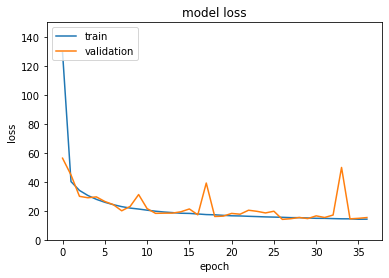

Test set:
MSE: 70.02
RMSE: 8.37
CMAPSS score: 1.86



NameError: name 'idx' is not defined

In [13]:
batch_size = 512
epochs = 200
layer_sizes = [256, 256, 512, 64]

results_path = os.path.join(output_path, "results_whole_training_set")
if not os.path.exists(results_path):
    os.makedirs(results_path)

results_file = os.path.join(results_path, "results.csv")
with open(results_file, "w") as file:
    file.write("experiment_num,selected_features,num_features,mse(mean),mse(std),rmse(mean),rmse(std),cmapss(mean),cmapss(std)\n")

x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train, 
                                                                          y_train, 
                                                                          test_size=0.3, 
                                                                          random_state=seed)
# Standardization
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_split)
x_val_scaled = scaler.transform(x_val_split)
input_dim = x_train_scaled.shape[1]

scaler_file = os.path.join(results_path, 'scaler.pkl')
with open(scaler_file, 'wb') as file:
    pickle.dump(scaler, file)

# Create model
weights_file = os.path.join(results_path, 'mlp_initial_weights.h5')
model_path = os.path.join(results_path, 'mlp_model_trained.h5')
model = create_mlp_model(input_dim, layer_sizes, activation='tanh', 
                         output_weights_file=weights_file)
model.summary()
    
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# Train model
history = train_model_existing_weights(model, weights_file, 
                                       x_train_scaled, y_train_split, 
                                       x_val_scaled, y_val_split, 
                                       batch_size=batch_size, 
                                       epochs=epochs, 
                                       callbacks=[es, mc])
    
history_file = os.path.join(results_path, "history.pkl")
save_history(history, history_file)
plot_loss_curves(history.history, output_path=results_path)
    
# Performance evaluation
x_test_scaled = scaler.transform(x_test)
    
loaded_model = load_model(model_path)
predictions_test = loaded_model.predict(x_test_scaled).flatten()
mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_test, y_test)

mse_mean, mse_std = mse, 0
rmse_mean, rmse_std = rmse, 0
cmapss_mean, cmapss_std = cmapss_score, 0
with open(results_file, "a") as file:
    file.write(f"{idx}, {feature_list_to_string(selected_columns)}, {len(selected_columns)}, {mse_mean}, {mse_std}, {rmse_mean}, {rmse_std}, {cmapss_mean}, {cmapss_std}\n")

Train set:
MSE: 13.60
RMSE: 3.69
CMAPSS score: 1.27

Test set:
MSE: 70.02
RMSE: 8.37
CMAPSS score: 1.86



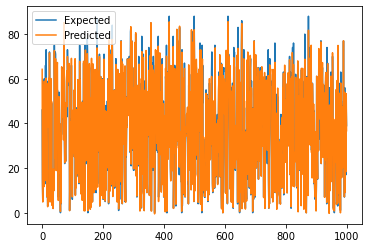

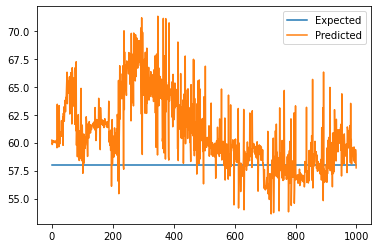

In [16]:
model_evaluation(loaded_model, x_test_scaled, y_test, x_train_scaled, y_train_split, plot_range=[0, 10**3])

In [11]:
###########################
# Evaluation
###########################

start_time = time.process_time()  
train_set, test_set, columns = load_dataset(filename)
print("Operation time (sec): " , (time.process_time() - start_time))
print()
print("Train set shape: " + str(train_set.shape))

columns_aux = columns[0] 
columns_health_params = columns[1] 
columns_sensor_measurements = columns[2] 
columns_virtual_sensors = columns[3]
columns_operating_conditions = columns[4] 
target_col = columns[5]

y_train = train_set['RUL']
x_train = train_set.drop(['RUL'], axis=1)

y_test = test_set['RUL']
x_test = test_set.drop(['RUL'], axis=1)

initial_columns = x_train.columns
selected_columns_1 = columns_sensor_measurements + columns_virtual_sensors + columns_operating_conditions

x_train.drop(labels=[x for x in initial_columns if x not in selected_columns_1], axis=1, inplace=True)

x_train, x_holdout, y_train, y_holdout = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)

Operation time (sec):  3.875

Train set shape: (5263447, 47)


In [14]:
initial_columns = x_train.columns
corr_th_list = [None, 0.99, 0.95, 0.9]

for corr_th in corr_th_list:
    print("Results CORR_TH = ", corr_th)
    results_folder = "results_all" if corr_th is None else "results_{}".format(corr_th)
    results_path = os.path.join(output_path, "corr_th_experiments", results_folder)
    model_path = os.path.join(results_path, "split_0", 'mlp_model_trained.h5')
    
    # Select features based on training set
    if corr_th is not None:
        selected_columns = get_non_correlated_features(x_train, corr_th=corr_th, debug=False)
    else:
        selected_columns = x_train.columns
    
    x_train_feature_selection = x_train[selected_columns]
    
    # Train-validation split for early stopping
    x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_feature_selection, 
                                                                              y_train, 
                                                                              test_size=0.3, 
                                                                              random_state=seed)

    # Standardization
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_split)
    x_val_scaled = scaler.transform(x_val_split)
    
    # Performance evaluation
    x_holdout_feature_selection = x_holdout[selected_columns]
    x_holdout_scaled = scaler.transform(x_holdout_feature_selection)

    x_test_feature_selection = x_test[selected_columns]
    x_test_scaled = scaler.transform(x_test_feature_selection)
    
    loaded_model = load_model(model_path)
    print("Holdout set: ")
    predictions_holdout = loaded_model.predict(x_holdout_scaled).flatten()
    mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_holdout, y_holdout)
    
    print("Test set: ")
    predictions_test = loaded_model.predict(x_test_scaled).flatten()
    mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_test, y_test)
    
    print("\n\n")

Results CORR_TH =  None
Holdout set: 
Test set:
MSE: 15.20
RMSE: 3.90
CMAPSS score: 1.30

Test set: 
Test set:
MSE: 45.96
RMSE: 6.78
CMAPSS score: 1.62




Results CORR_TH =  0.99
Holdout set: 
Test set:
MSE: 13.92
RMSE: 3.73
CMAPSS score: 1.28

Test set: 
Test set:
MSE: 70.63
RMSE: 8.40
CMAPSS score: 1.87




Results CORR_TH =  0.95
Holdout set: 
Test set:
MSE: 31.93
RMSE: 5.65
CMAPSS score: 1.58

Test set: 
Test set:
MSE: 73.66
RMSE: 8.58
CMAPSS score: 1.90




Results CORR_TH =  0.9
Holdout set: 
Test set:
MSE: 30.81
RMSE: 5.55
CMAPSS score: 1.56

Test set: 
Test set:
MSE: 64.30
RMSE: 8.02
CMAPSS score: 1.83






In [16]:
initial_columns = x_train.columns
corr_th_list = [None, 0.99, 0.95, 0.9]

for corr_th in corr_th_list:
    print("Results CORR_TH = ", corr_th)
    results_folder = "results_all" if corr_th is None else "results_{}".format(corr_th)
    results_path = os.path.join(output_path, "corr_th_experiments", results_folder)
    
    # Select features based on training set
    if corr_th is not None:
        selected_columns = get_non_correlated_features(x_train, corr_th=corr_th, debug=False)
    else:
        selected_columns = x_train.columns
    
    x_train_feature_selection = x_train[selected_columns]
    
    # Train-validation split for early stopping
    x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_feature_selection, 
                                                                              y_train, 
                                                                              test_size=0.3, 
                                                                              random_state=seed)

    # Standardization
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_split)

    x_test_feature_selection = x_test[selected_columns]
    x_test_scaled = scaler.transform(x_test_feature_selection)
    
    mse_vals = []
    rmse_vals = []
    cmapss_vals = []
    
    for split_no in range(3):
        model_path = os.path.join(results_path, f"split_{split_no}", 'mlp_model_trained.h5')
        loaded_model = load_model(model_path)

        predictions_test = loaded_model.predict(x_test_scaled).flatten()
        mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_test, y_test)

        mse_vals.append(mse)
        rmse_vals.append(rmse)
        cmapss_vals.append(cmapss_score)
    
    mse_mean = np.mean(mse_vals)
    mse_std = np.std(mse_vals)
    rmse_mean = np.mean(rmse_vals)
    rmse_std = np.std(rmse_vals)
    cmapss_mean = np.mean(cmapss_vals)
    cmapss_std = np.std(cmapss_vals)
    
    print("\nMSE mean = {}\nMSE std = {}\n".format(mse_mean, mse_std))      
    print("\nRMSE mean = {}\nRMSE std = {}\n".format(rmse_mean, rmse_std))
    print("\nCMAPSS mean = {}\nCMAPSS std = {}\n".format(cmapss_mean, cmapss_std))

Results CORR_TH =  None
Test set:
MSE: 45.96
RMSE: 6.78
CMAPSS score: 1.62

Test set:
MSE: 50.61
RMSE: 7.11
CMAPSS score: 1.67

Test set:
MSE: 49.85
RMSE: 7.06
CMAPSS score: 1.65


MSE mean = 48.8061641708166
MSE std = 2.03701923144007


RMSE mean = 6.98459820093371
RMSE std = 0.14680647918325718


CMAPSS mean = 1.646654278030259
CMAPSS std = 0.022963143047180595

Results CORR_TH =  0.99
Test set:
MSE: 70.63
RMSE: 8.40
CMAPSS score: 1.87

Test set:
MSE: 75.85
RMSE: 8.71
CMAPSS score: 1.92

Test set:
MSE: 65.48
RMSE: 8.09
CMAPSS score: 1.83


MSE mean = 70.65527531693327
MSE std = 4.235095464131678


RMSE mean = 8.401888716344407
RMSE std = 0.25207402701944215


CMAPSS mean = 1.8723792630508644
CMAPSS std = 0.03621536967804698

Results CORR_TH =  0.95
Test set:
MSE: 73.66
RMSE: 8.58
CMAPSS score: 1.90

Test set:
MSE: 66.68
RMSE: 8.17
CMAPSS score: 1.85

Test set:
MSE: 57.22
RMSE: 7.56
CMAPSS score: 1.76


MSE mean = 65.85140225080023
MSE std = 6.735034371109586


RMSE mean = 8.104124435